<a href="https://colab.research.google.com/github/jtmonroe/FreeCodeCamp-Dog-Cat/blob/main/fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We ought to remove `ImageDataGenerator` since it is deprcated in the API. We can replace it with `image_dataset_from_directory` as per

In [63]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, \
  Dense, Conv2D, Flatten, Dropout, MaxPooling2D, \
  Rescaling, Resizing, RandomFlip, RandomRotation, \
  RandomZoom, RandomSharpness, RandomContrast, BatchNormalization, \
  RandomTranslation, RandomBrightness
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data import Dataset


import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

It takes longer to print the unzip of the files than it does to unzip them. Send to the null zone.

In [64]:
# Get project files
if not Path("cats_and_dogs.zip").exists():
  !wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

if not Path("cats_and_dogs/").exists():
  !unzip cats_and_dogs.zip > /dev/null

In [65]:
PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [66]:
# 3
def from_directory(directory, labels):
  return image_dataset_from_directory(
      directory,
      labels,
      label_mode='binary',
      image_size=(IMG_HEIGHT, IMG_WIDTH),
      batch_size=batch_size
  )

train_image_generator = from_directory(train_dir, labels='inferred')
validation_image_generator = from_directory(validation_dir, labels='inferred')
test_image_generator = from_directory(test_dir, labels=None)

train_data_gen = iter(train_image_generator)
val_data_gen = iter(validation_image_generator)
test_data_gen = iter(test_image_generator)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 50 files.


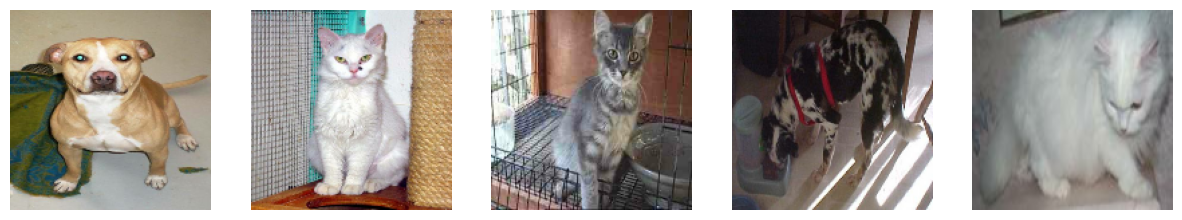

In [67]:
# 4
def plotImages(images_arr, probabilities = False):
    data_fixing = Sequential([
      Resizing(IMG_HEIGHT, IMG_WIDTH),
      Rescaling(1./255),
      RandomFlip("horizontal"),
    ])
    fig, axes = plt.subplots(1, len(images_arr), figsize=(len(images_arr) * 3, 5))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(data_fixing(img))
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [68]:
# 5 Doing this with Layers instead
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomContrast(0.1),
    RandomSharpness(0.1),
    RandomBrightness(0.3),
])


# def add_randoms(image, label, expansion=3):
#   new_dataset = Dataset.from_tensors((image, label))
#   for _ in range(expansion):
#     new_dataset.concatenate(Dataset.from_tensors((data_augmentation(image, training=True), label)))
#   return new_dataset

# train_image_generator = from_directory(train_dir, 'inferred').flat_map(add_randoms)



Found 2000 files belonging to 2 classes.


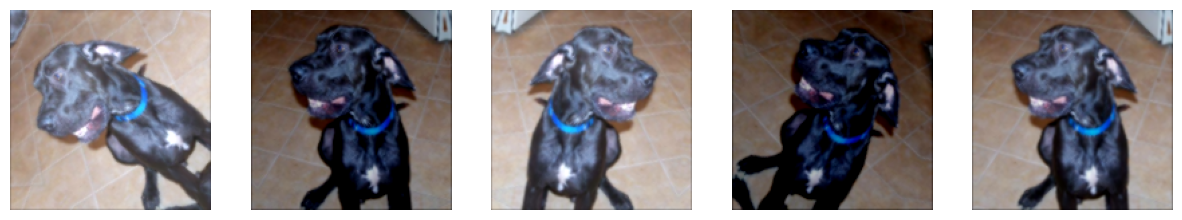

In [69]:
# 6
# x, _ = next(iter(train_image_generator.take(1)))
# augmented_images = [data_augmentation(x)[0] for _ in range(5)]
# plotImages(augmented_images)

In [73]:
# 7
def ConvLayer(filters):
  return [
    Conv2D(filters, 6, activation='relu', padding='same', data_format="channels_last"),
    BatchNormalization(axis=3),
    MaxPooling2D(),
  ]

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomContrast(0.1),
    RandomSharpness(0.1),
    RandomBrightness(0.3),
])

model = Sequential([
  InputLayer(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  data_augmentation,
  Rescaling(1./255),
  *ConvLayer(16),
  *ConvLayer(32),
  *ConvLayer(64),
  Dropout(0.5),
  Flatten(),
  Dense(128, activation='relu'),
  Dropout(0.5),
  Dense(1, name = "out", activation='sigmoid')
])

model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_23 (Sequential)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_19 (Rescaling)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 150, 150, 16)        │           1,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 150, 150, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 75, 75, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 75, 75, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 37, 37, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 37, 37, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │       2,654,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ out (Dense)                          │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,748,913 (10.49 MB)

 Trainable params: 2,748,689 (10.49 MB)

 Non-trainable params: 224 (896.00 B)

In [74]:
# 8
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=10,
  decay_rate=0.5,
  staircase=False
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  mode="min",
                                  patience=3,
                                  restore_best_weights=True)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy'],
    optimizer=tf.keras.optimizers.Adam(lr_schedule)
)
history = model.fit(
    train_image_generator.cache(),
    validation_data=validation_image_generator.cache(),
    epochs=epochs,
    callbacks=[callback]
)

Epoch 1/15
     16/Unknown 122s 7s/step - accuracy: 0.5267 - loss: 3.6094

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


16/16 ━━━━━━━━━━━━━━━━━━━━ 168s 10s/step - accuracy: 0.5262 - loss: 3.5388 - val_accuracy: 0.4690 - val_loss: 0.7078
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 109s 7s/step - accuracy: 0.5568 - loss: 0.7733 - val_accuracy: 0.5530 - val_loss: 0.7018
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 117s 7s/step - accuracy: 0.5432 - loss: 0.7002 - val_accuracy: 0.5330 - val_loss: 0.7825
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 133s 7s/step - accuracy: 0.5746 - loss: 0.6798 - val_accuracy: 0.5500 - val_loss: 0.8399
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 107s 7s/step - accuracy: 0.5960 - loss: 0.6613 - val_accuracy: 0.5520 - val_loss: 0.8948


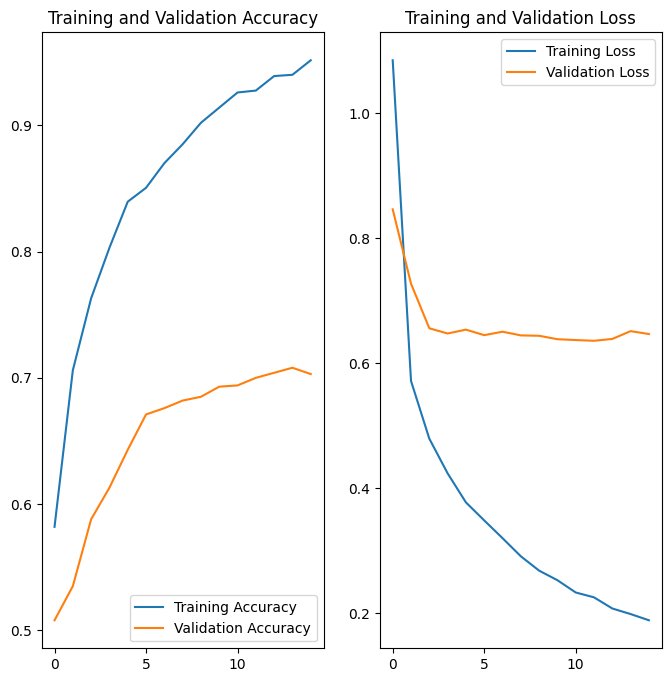

In [46]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [51]:
# 10

probabilities = model.predict(test_image_generator.repeat(), steps=10).flatten()

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step


In [52]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 54.0% of the images of cats and dogs.
You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!
